In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

import contextlib
import os
from importlib import reload

import torchvision
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']
plt.rcParams['font.size'] = 12

In [2]:
import renyi
import utils
from renyi import renyi_mixture_divergence, rbf_kernel, poly_kernel, generic_kernel
from renyi import test_mixture_divergence, renyi_mixture_divergence_stable
from renyi import renyi_mixture_divergence, renyi_sim_divergence, renyi_sim_divergence_stable

In [3]:
# torch.set_default_dtype(torch.float64)

class GeneratorFC(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(GeneratorFC, self).__init__()
        self.layers = []

        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.BatchNorm1d(hidden_dim))
            self.layers.append(nn.LeakyReLU())
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))

        self.layer_module = nn.ModuleList(self.layers)

    def forward(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

In [4]:
from sklearn.datasets.samples_generator import make_swiss_roll

d, z_dim, gen_hiddens = 2, 16, [256, 256]
batch_size_p = 600
batch_size_q = 600

In [32]:
generator = GeneratorFC(z_dim, d, gen_hiddens).cuda()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))

In [39]:
alpha = 1e-4
sigma_mult = 1

# emp_probs = 2*torch.ones(1, batch_size//2).cuda()/batch_size
emp_probs_p = torch.ones(1, batch_size_p).cuda()/batch_size_p
emp_probs_q = torch.ones(1, batch_size_q).cuda()/batch_size_q

kernel = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[0.2 * sigma_mult], log=True))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: multiquad_kernel(u, v, sigma=0.2))
# kernel = lambda x, y: generic_kernel(x, y, lambda u, v: poly_kernel(u, v, degree=2))

D = lambda x, y: renyi_mixture_divergence_stable(emp_probs_p, x, emp_probs_q, y, kernel, alpha,
                                                 use_avg=False, use_full=False, symmetric=True)

# D = lambda x, y: test_mixture_divergence(emp_probs_p, x, emp_probs_q, y, kernel,
#                                          symmetric=True, use_avg=False)

for g in g_optimizer.param_groups:
    g['lr'] = 1e-4

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_q, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)

#         x = x_real[:batch_size//2]
#         x_prime = x_real[batch_size//2:]
#         y = x_fake[:batch_size//2]
#         y_prime = x_fake[batch_size//2:]

#         loss = D(x, y) + D(x_prime, y) + D(x, y_prime) + D(x_prime, y_prime) - 2*D(y, y_prime)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.0167
200 - 0.0240
400 - 0.0179
600 - 0.0240
800 - 0.0125
1000 - 0.0246
1200 - 0.0139
1400 - 0.0148
1600 - 0.0231
1800 - 0.0145
2000 - 0.0171
2200 - 0.0167
2400 - 0.0161
2600 - 0.0133
2800 - 0.0145
3000 - 0.0174
3200 - 0.0240
3400 - 0.0195
3600 - 0.0132
3800 - 0.0107
4000 - 0.0172
4200 - 0.0131
4400 - 0.0123
4600 - 0.0147
4800 - 0.0111


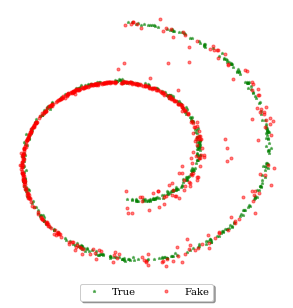

In [40]:
x_real = make_swiss_roll(500, noise=0.1)[0][:, [0, 2]]/10
z = torch.randn(500, z_dim).cuda()
x_fake = generator(z).data.cpu().numpy()

plt.figure(figsize=(5, 5))
plt.plot(x_real[:, 0], x_real[:, 1], 'g*', alpha=0.5, label='True', markersize=3)
plt.plot(x_fake[:, 0], x_fake[:, 1], 'ro', alpha=0.5, label='Fake', markersize=3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.00), fancybox=True, shadow=True, ncol=2);

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)

cur_axes.spines['top'].set_visible(False)
cur_axes.spines['right'].set_visible(False)
cur_axes.spines['bottom'].set_visible(False)
cur_axes.spines['left'].set_visible(False)

plt.savefig('swiss_roll.pdf', dpi=100)

In [354]:
bs1, bs2, n = 100, 80, 10
# bs1, bs2, n = 4, 2, 5

K = torch.rand(n, n).double()
for i in range(n):
    K[i,i] = 1.0
K = (K + K.t()) / 2
log_K = torch.log(K)

# K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=False))
# log_K = lambda x, y: generic_kernel(x, y, lambda u, v: rbf_kernel(u, v, sigmas=[2], log=True))

p = torch.rand(bs1, n).double()
p[:, 1] = 0
p = p / p.sum(dim=1, keepdim=True)
q = torch.rand(bs1, n).double()
q[:, 0] = 0
q = q / q.sum(dim=1, keepdim=True)

Y = torch.randn(bs1, n).double() * 2
X = torch.randn(bs2, n).double()

alpha, P1 = 1, False

In [355]:
renyi_sim_divergence(K, p, q, alpha, P1).abs().sum(), renyi_sim_divergence_stable(log_K, p, q, alpha, P1).abs().sum()

(tensor(13.8918, dtype=torch.float64), tensor(13.8918, dtype=torch.float64))

In [6]:
from sinkhorn_pointcloud import sinkhorn_normalized

In [13]:
epsilon = 0.02
niter = 10
D = lambda x, y: sinkhorn_normalized(x, y, epsilon, batch_size_p, niter)

for _ in range(5000):
    
    g_optimizer.zero_grad()
    
    x_real = torch.Tensor(make_swiss_roll(batch_size_p, noise=0.1)[0][:, [0, 2]]/10).cuda()
    x_real += 0.01 * torch.randn_like(x_real)
    
    z = torch.randn(batch_size_p, z_dim).cuda()
    with contextlib.nullcontext():  # autograd.detect_anomaly():
        x_fake = generator(z)
        loss = D(x_real, x_fake)

        if _ % 200 == 0:
            print("%d - %.4f" % (_, loss.item()))

        loss.backward()

    g_optimizer.step()

0 - 0.8522
200 - 0.0915
400 - 0.0725
600 - 0.0474
800 - 0.0247
1000 - 0.0217
1200 - 0.0186
1400 - 0.0152
1600 - 0.0156
1800 - 0.0187


KeyboardInterrupt: 

In [7]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

import utils


class Model(nn.Module):

    def __init__(self, size=4, alpha=1, n=100, d=2, sigma=1, half_empty=True):
        super().__init__()
        self.alpha = alpha
        self.d = d
        self.sigma = sigma
        self.size = size
        self.half_empty = half_empty

        loc_t = torch.randn(size, n)
        loc_t[-1] = loc_t[0]
        self.locs = nn.Parameter(loc_t)
        if half_empty:
            self.p = nn.Parameter(torch.randn(1, size // 2))
        else:
            self.p = nn.Parameter(torch.randn(1, size))
        self.q = nn.Parameter(torch.randn(1, size))

    def forward(self):
        log_K = -(utils.batch_pdist(self.locs, self.locs) / self.sigma) ** self.d
        if self.half_empty:
            p = torch.cat([F.softmax(self.p, dim=1), torch.zeros_like(self.p)], dim=1)
        else:
            p = F.softmax(self.p, dim=1)
        q = F.softmax(self.q, dim=1)

        log_pK = torch.logsumexp(log_K[None, ...] + torch.log(p[:, None, :]), dim=2)
        log_qK = torch.logsumexp(log_K[None, ...] + torch.log(q[:, None, :]), dim=2)

        rat1 = (log_pK, log_qK)
        rat2 = (log_qK, log_pK)

        if np.abs(self.alpha - 1.0) < 1e-8:
            dp1 = (p * (rat1[0] - rat1[1])).sum(-1)
            dp2 = (q * (rat2[0] - rat2[1])).sum(-1)
            loss = 0.5 * (dp1 + dp2)
        else:
            power_pq = torch.log(p) + (self.alpha - 1) * (rat1[0] - rat1[1])
            power_qp = torch.log(q) + (self.alpha - 1) * (rat2[0] - rat2[1])
            loss = 0.5 * (1 / (self.alpha - 1)) * (torch.logsumexp(power_pq, -1) + torch.logsumexp(power_qp, -1))

        return loss, p, q, log_K

In [4]:
def fail_triangle(log_K):
    dist = torch.sqrt(-log_K)
    locs = []
    for row in range(dist.shape[0]):
        for col in range(row + 1):
            locs.append((row, col))
    for i in range(len(locs)):
        row, col = locs[i]
        for k in range(dist.shape[0]):
            if dist[row, col] > dist[row, k] + dist[k, col]:
                print(row, col, k)
                print(dist[row, col], dist[row, k], dist[k, col])
                return True
    return False

In [9]:
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float64)

n = 2
size = 5
for half_empty in [False, True]:
    for alpha in [0.5, 1, 2]:
        print('n', n, 'alpha', alpha, 'size', size, 'half_empty', half_empty)
        model = Model(alpha=alpha, size=size, half_empty=half_empty, n=n).cuda()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.5, 0.9))

        for itr in range(20000):
            optimizer.zero_grad()
            loss, p, q, log_K = model()
            if loss < -1e-5:
                break
#             if not itr:
#                 assert not fail_triangle(log_K)
            if itr % 500 == 0:
                print(loss)
#                 if loss < -1e-6:
#                     assert fail_triangle(log_K)
            loss.backward()
            optimizer.step()

        print()

n 2 alpha 0.5 size 5 half_empty False
tensor([0.0232], device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.0102], device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.0028], device='cuda:0', grad_fn=<MulBackward0>)
tensor([0.0005], device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.2759e-05], device='cuda:0', grad_fn=<MulBackward0>)
tensor([5.4800e-10], device='cuda:0', grad_fn=<MulBackward0>)
tensor([7.6775e-10], device='cuda:0', grad_fn=<MulBackward0>)
tensor([9.1535e-11], device='cuda:0', grad_fn=<MulBackward0>)
tensor([9.4295e-11], device='cuda:0', grad_fn=<MulBackward0>)
tensor([3.7609e-11], device='cuda:0', grad_fn=<MulBackward0>)
tensor([5.5259e-12], device='cuda:0', grad_fn=<MulBackward0>)
tensor([3.5333e-10], device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.4048e-11], device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.6333e-10], device='cuda:0', grad_fn=<MulBackward0>)
tensor([5.0863e-10], device='cuda:0', grad_fn=<MulBackward0>)
tensor([1.0075e-10], device='cuda:0', grad_fn=<M

RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 2